# Requerimiento 5: Análisis Geográfico de Autores

## Descripción del Requerimiento

Este notebook implementa un análisis geográfico de la distribución de autores de artículos científicos.

### Objetivos:
1. Parsear archivos BibTeX y extraer información de autores
2. Enriquecer datos usando la API de Crossref para obtener afiliaciones institucionales
3. Identificar países de los autores mediante fuzzy matching
4. Visualizar la distribución geográfica en mapas de calor interactivos

### Flujo del Proceso:
```
Archivo .bib → Parsing → Extracción de DOI → API Crossref → 
Identificación de País → Agregación → Visualización (Choropleth)
```

### Tecnologías Utilizadas:
- **bibtexparser**: Lectura de archivos bibliográficos
- **Crossref API**: Enriquecimiento de metadatos
- **pycountry**: Normalización de códigos de países
- **rapidfuzz**: Fuzzy matching para identificación de países
- **Plotly**: Visualizaciones interactivas de mapas

## 1. Configuración Inicial y Carga de Librerías

Esta sección configura todas las dependencias necesarias y define las funciones auxiliares para el procesamiento.

### Funciones Principales:

#### `parse_bib_to_df(bib_path, max_entries=None)`
Convierte un archivo BibTeX a un DataFrame de pandas con los siguientes campos:
- `id`: Identificador único del artículo
- `title`: Título del artículo
- `authors`: Lista completa de autores
- `first_author`: Primer autor (extraído)
- `doi`: Digital Object Identifier
- `year`: Año de publicación
- `venue`: Revista o conferencia
- `abstract`: Resumen del artículo
- `keywords`: Palabras clave

#### `extract_first_author(authors_str)`
Extrae el apellido del primer autor de la cadena de autores en formato BibTeX.

#### `enrich_by_doi(doi, email=None, sleep=1.0)`
Consulta la API de Crossref usando el DOI para obtener:
- Afiliación institucional del primer autor
- País inferido de la afiliación
- Código ISO del país

#### `batch_enrich(df, cache_path, email=None, sleep=1.0, max_rows=None)`
Procesa múltiples registros en lote, utilizando un sistema de caché para evitar consultas repetidas a la API.

### Notas Importantes:
- **Rate Limiting**: Se incluye un `sleep` de 1 segundo entre peticiones para respetar los límites de Crossref
- **Cache**: Los resultados se guardan en `country_lookup.csv` para reutilización

In [26]:
# Pipeline inicial para Requerimiento 5
# - parsear archivo .bib grande a un DataFrame
# - extraer primer autor y campos clave
# - enriquecer por DOI usando Crossref (con cache) para obtener afiliación/pais

import importlib, subprocess, sys, os, time, json, re
from pathlib import Path

# Imports principales (después de instalar si es necesario)
import bibtexparser
import pandas as pd
import requests
import pycountry
from tqdm import tqdm
from rapidfuzz import fuzz, process

# ---------- Utilidades de parseo y normalización ----------
def parse_bib_to_df(bib_path, max_entries=None):
    """Parsea un archivo .bib a un DataFrame con campos clave.
    Devuelve pandas.DataFrame con columnas: id, title, authors, first_author, doi, year, venue, abstract, keywords, raw_entry
    """
    bib_text = Path(bib_path).read_text(encoding='utf-8', errors='ignore')
    bib_db = bibtexparser.loads(bib_text)
    rows = []
    for i, entry in enumerate(bib_db.entries):
        if max_entries is not None and i >= max_entries:
            break
        eid = entry.get('ID') or entry.get('key') or f'row{i}'
        title = entry.get('title','').strip()
        authors = entry.get('author','').strip()
        doi = entry.get('doi','').strip()
        year = entry.get('year','').strip()
        venue = entry.get('journal', entry.get('booktitle','')).strip()
        abstract = entry.get('abstract','').strip()
        keywords = entry.get('keywords', entry.get('keyword','')).strip()
        raw = str(entry)
        first_author = extract_first_author(authors)
        rows.append({
            'id': eid,
            'title': title,
            'authors': authors,
            'first_author': first_author,
            'doi': doi,
            'year': year,
            'venue': venue,
            'abstract': abstract,
            'keywords': keywords,
            'raw_entry': raw,
        })
    df = pd.DataFrame(rows)
    return df


def extract_first_author(authors_str):
    if not authors_str:
        return ''
    # BibTeX authors are usually separated by ' and '
    parts = [p.strip() for p in authors_str.split(' and ')]
    first = parts[0] if parts else ''
    # Normalize formats like 'Last, First' -> 'Last' or 'First Last' -> 'Last'
    if ',' in first:
        last = first.split(',')[0].strip()
    else:
        toks = first.split()
        last = toks[-1] if toks else first
    return last

# ---------- Enriquecimiento: Crossref + heurísticas ----------
COUNTRIES = [c.name.lower() for c in pycountry.countries]
# Add some common aliases
ALIASES = {'usa':'united states','us':'united states','u.s.a.':'united states','uk':'united kingdom','england':'united kingdom'}

def find_country_in_text(text):
    if not text:
        return None
    t = text.lower()
    # direct match country names
    for cname in COUNTRIES:
        if cname in t:
            return cname.title()
    # aliases
    for a,v in ALIASES.items():
        if a in t:
            return v.title()
    return None


def enrich_by_doi(doi, email=None, sleep=1.0):
    """Consulta Crossref por DOI y trata de extraer afiliación/pais del primer autor.
    Devuelve dict con keys: affiliation_raw, country, country_iso2, source, confidence
    """
    if not doi:
        return {'affiliation_raw':'','country':'','country_iso2':'','source':'','confidence':0.0}
    # normalize doi for URL (remove leading DOI: if present)
    doi_clean = doi.strip()
    doi_clean = doi_clean.replace('doi:','').replace('DOI:','').strip()
    url = f'https://api.crossref.org/works/{requests.utils.requote_uri(doi_clean)}'
    headers = {'User-Agent': f'proyecto-analisis-algoritmos (mailto:{email})' if email else 'proyecto-analisis-algoritmos'}
    try:
        r = requests.get(url, headers=headers, timeout=20)
        if r.status_code != 200:
            return {'affiliation_raw':'','country':'','country_iso2':'','source':'crossref','confidence':0.0}
        data = r.json()
        msg = data.get('message', {})
        authors = msg.get('author', [])
        if not authors:
            return {'affiliation_raw':'','country':'','country_iso2':'','source':'crossref','confidence':0.0}
        first = authors[0]
        affs = first.get('affiliation', [])
        aff_text = ''
        if affs:
            # affiliation is often list of dicts with 'name'
            if isinstance(affs, list):
                aff_text = ' '.join([a.get('name','') for a in affs if isinstance(a, dict)])
            else:
                aff_text = str(affs)
        # try to find country in affiliation text
        country = find_country_in_text(aff_text)
        country_iso = ''
        if country:
            try:
                c = pycountry.countries.get(name=country) or pycountry.countries.get(common_name=country)
                if c:
                    country_iso = c.alpha_2
            except Exception:
                country_iso = ''
        # sleep to respect rate limits
        time.sleep(sleep)
        return {'affiliation_raw':aff_text, 'country': country.title() if country else '', 'country_iso2': country_iso, 'source':'crossref', 'confidence': 0.9 if country else 0.5}
    except Exception as e:
        # error contacting crossref
        return {'affiliation_raw':'','country':'','country_iso2':'','source':'crossref_error','confidence':0.0, 'error': str(e)}


def load_cache(path):
    if not os.path.exists(path):
        return {}
    try:
        return pd.read_csv(path, dtype=str).set_index('id').to_dict(orient='index')
    except Exception:
        return {}


def save_cache(dct, path):
    df = pd.DataFrame.from_dict(dct, orient='index')
    df.index.name = 'id'
    df.reset_index(inplace=True)
    df.to_csv(path, index=False, encoding='utf-8')


def batch_enrich(df, cache_path='country_lookup.csv', email=None, sleep=1.0, max_rows=None):
    cache = load_cache(cache_path)
    updated = False
    total = len(df) if max_rows is None else min(len(df), max_rows)
    for idx in tqdm(range(total)):
        row = df.iloc[idx]
        rid = row['id']
        if rid in cache:
            continue
        doi = row.get('doi','')
        if not doi:
            # try heuristics on raw_entry
            aff = find_country_in_text(row.get('raw_entry',''))
            cache[rid] = {'doi': doi, 'affiliation_raw': row.get('raw_entry',''), 'country': aff.title() if aff else '', 'country_iso2': '', 'source':'heuristic' if aff else '', 'confidence': 0.3 if aff else 0.0}
            updated = True
            continue
        res = enrich_by_doi(doi, email=email, sleep=sleep)
        rowd = {'doi': doi, 'affiliation_raw': res.get('affiliation_raw',''), 'country': res.get('country',''), 'country_iso2': res.get('country_iso2',''), 'source': res.get('source',''), 'confidence': res.get('confidence',0.0)}
        cache[rid] = rowd
        updated = True
    if updated:
        save_cache(cache, cache_path)
    return cache

# ---------- Guardar registros y preparar estado para la nube ----------
def prepare_state_files(df, out_dir='proyecto/requerimiento5/data'):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    records_path = Path(out_dir)/'records.csv'
    df.to_csv(records_path, index=False, encoding='utf-8')
    # frequencies.json placeholder
    freq_path = Path(out_dir)/'frequencies.json'
    if not freq_path.exists():
        with open(freq_path,'w',encoding='utf-8') as f:
            json.dump({'total_terms':0,'terms':{}}, f, ensure_ascii=False, indent=2)
    return records_path, Path(out_dir)/'country_lookup.csv', freq_path

print('Módulo cargado')


Módulo cargado


## 2. Procesamiento del Archivo BibTeX

Esta celda ejecuta el pipeline completo de procesamiento.

### Pasos Ejecutados:

#### 2.1 Parsing del Archivo
```python
df = parse_bib_to_df(BIB_PATH, max_entries=None)
```
- Lee el archivo `.bib` especificado
- Extrae todos los campos relevantes
- Crea un DataFrame estructurado

#### 2.2 Preparación de Archivos de Estado
```python
records_csv, country_cache_path, freq_path = prepare_state_files(df, out_dir=OUT_DIR)
```
- Guarda los registros parseados en `data/records.csv`
- Crea el archivo de caché `data/country_lookup.csv`
- Prepara archivo de frecuencias (placeholder)

#### 2.3 Enriquecimiento con Crossref API
```python
cache = batch_enrich(df, cache_path=str(country_cache_path), email=email, sleep=1.0, max_rows=None)
```
- Consulta Crossref para cada DOI
- Extrae afiliaciones institucionales
- Identifica países mediante fuzzy matching
- Guarda resultados en caché

### Tiempo de Ejecución:
- **Parsing**: Segundos
- **Enriquecimiento**: ~1 segundo por artículo (rate limiting)
- **Total**: Variable según cantidad de artículos

### Optimizaciones:
- El sistema de caché evita reprocesar artículos ya consultados
- Si se interrumpe, puede continuar desde donde quedó
- Para datasets grandes, considerar ejecutar por lotes

In [27]:

BIB_PATH = '../primeros_' \
'500.bib'  
OUT_DIR = 'data'


print('Parsing completo del archivo .bib — esto puede tardar dependiendo del tamaño.')
df = parse_bib_to_df(BIB_PATH, max_entries=None)
print(f'Parsed {len(df)} records (total)')

# Guardar registros y preparar archivos de estado
records_csv, country_cache_path, freq_path = prepare_state_files(df, out_dir=OUT_DIR)
print('Records guardados en', records_csv)

# Enriquecer por DOI 
# Para evitar bloqueos, procesa con sleep>=1.0 
email = ''  # opcional: si se nos bloquea las peticiones poner un correo para User-Agent en Crossref

cache = batch_enrich(df, cache_path=str(country_cache_path), email=email, sleep=1.0, max_rows=None)
print('Enriquecimiento finalizado. Caché guardada en', country_cache_path)

# Mostrar estadísticas de cobertura
covered = sum(1 for v in cache.values() if v.get('country'))
print(f'Paises asignados: {covered} / {len(df)} = {covered/len(df):.2%}')

# Frecuencias (placeholder)
print('Fichero de frecuencias (placeholder):', freq_path)


Parsing completo del archivo .bib — esto puede tardar dependiendo del tamaño.
Parsed 500 records (total)
Records guardados en data/records.csv


100%|██████████| 500/500 [00:00<00:00, 47745.01it/s]

Enriquecimiento finalizado. Caché guardada en data/country_lookup.csv
Paises asignados: 500 / 500 = 100.00%
Fichero de frecuencias (placeholder): data/frequencies.json


## 3. Visualización Geográfica - Mapa de Calor (Choropleth)

Esta celda genera un mapa de calor interactivo que muestra la distribución geográfica de las publicaciones por país.

### Proceso de Visualización:

#### 3.1 Carga de Datos
```python
records = pd.read_csv(records_path, dtype=str)
cache = pd.read_csv(cache_path, dtype=str)
merged = records.merge(cache[['id','country','country_iso2']], on='id', how='left')
```
- Carga los registros procesados
- Carga la caché de países
- Combina ambos datasets

#### 3.2 Agregación por País
```python
agg = merged.groupby(['country','country_iso2']).size().reset_index(name='count')
```
- Cuenta publicaciones por país
- Agrupa por código ISO2

#### 3.3 Normalización de Códigos
```python
agg['iso3'] = agg['country_iso2'].apply(iso2_to_iso3)
```
- Convierte códigos ISO-2 a ISO-3 (requerido por Plotly)
- Maneja casos especiales y aliases
- Valida códigos con pycountry

#### 3.4 Generación del Mapa
```python
fig = px.choropleth(df_plot, locations='iso3', color='count', 
                    hover_name='country', color_continuous_scale='Viridis',
                    projection='natural earth')
```
- Crea mapa choropleth interactivo
- Escala de colores: Viridis (amarillo = más publicaciones)
- Proyección: Natural Earth (visualmente balanceada)

### Archivos Generados:

Intentos de exportación:
1. **PDF directo** (`outputs/mapa_paises.pdf`) - Requiere kaleido
2. **PNG + conversión** (`outputs/mapa_paises.png`) - Fallback con Pillow
3. **HTML interactivo** - Visualización en el notebook

### Interpretación del Mapa:
- **Colores cálidos** (amarillo/verde claro): Mayor concentración de publicaciones
- **Colores fríos** (azul/morado): Menor concentración
- **Gris**: Sin datos disponibles
- **Hover**: Muestra nombre del país y cantidad exacta


## 4. Resultados y Análisis

### Estadísticas del Procesamiento

Métricas típicas del procesamiento:

#### Cobertura de Datos:
- **Total de artículos procesados**: Variable según dataset
- **Países identificados**: Típicamente 70-80% de cobertura
- **Artículos sin país**: 20-30%

#### Causas de Artículos sin País:
1. **Sin DOI**: Artículos sin identificador digital
2. **Sin afiliación en Crossref**: DOI sin datos de afiliación
3. **País no identificable**: Afiliación sin país extraíble

### Distribución Geográfica

Patrones típicos en literatura científica:

#### Concentración por Región:
- **América del Norte**: Alta concentración
- **Asia**: Crecimiento significativo
- **Europa**: Distribución equilibrada
- **Oceanía**: Participación moderada
- **América del Sur**: Participación emergente
- **África**: Participación limitada

### Insights del Análisis

#### Concentración Geográfica:
- La investigación tiende a estar concentrada en países desarrollados
- Los países principales representan la mayoría de las publicaciones
- Existe brecha entre países desarrollados y en desarrollo

#### Tendencias Observadas:
- **Dominio anglosajón**: Países de habla inglesa
- **Crecimiento asiático**: Países del este asiático
- **Europa occidental**: Países de Europa occidental
- **Emergentes**: Países en desarrollo con crecimiento reciente

### Análisis Adicionales Posibles

#### 1. Evolución Temporal
```python
# Analizar cambios en distribución geográfica por año
temporal_analysis = merged.groupby(['year', 'country']).size()
```

#### 2. Colaboraciones Internacionales
```python
# Identificar artículos con autores de múltiples países
multi_country_papers = merged[merged['authors'].str.contains(' and ')]
```

#### 3. Instituciones Líderes
```python
# Extraer y rankear instituciones por país
top_institutions = cache.groupby(['country', 'affiliation_raw']).size()
```

#### 4. Análisis de Temas por País
```python
# Cruzar con keywords para ver especialización por país
country_topics = merged.groupby('country')['keywords'].apply(lambda x: ' '.join(x))
```

### Archivos Generados

Los siguientes archivos están disponibles en la carpeta `data/`:

1. **`records.csv`**: Todos los artículos parseados con metadatos
2. **`country_lookup.csv`**: Caché de países identificados por artículo
3. **`frequencies.json`**: Placeholder para análisis de frecuencias

En la carpeta `outputs/`:
- **`mapa_paises.pdf`** o **`mapa_paises.png`**: Visualización del mapa

### Próximos Pasos

#### Mejoras Recomendadas:
1. **Aumentar cobertura**: Procesar datasets completos
2. **Validación manual**: Revisar muestra de países identificados
3. **Enriquecimiento adicional**: Usar otras APIs (OpenAlex, Semantic Scholar)
4. **Análisis temporal**: Estudiar evolución de distribución por año
5. **Redes de colaboración**: Mapear co-autorías internacionales

#### Optimizaciones:
1. **Procesamiento paralelo**: Usar `concurrent.futures` para múltiples peticiones
2. **Cache persistente**: Usar base de datos SQLite en lugar de CSV
3. **Fuzzy matching mejorado**: Entrenar modelo específico para afiliaciones
4. **Geocodificación**: Obtener coordenadas para visualizaciones más detalladas

### Referencias

- **Crossref API**: https://api.crossref.org/
- **Plotly Choropleth**: https://plotly.com/python/choropleth-maps/
- **pycountry**: https://pypi.org/project/pycountry/
- **rapidfuzz**: https://github.com/maxbachmann/RapidFuzz

In [28]:
import pandas as pd
import pycountry
import plotly.express as px
from pathlib import Path

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

records_path = Path('data/records.csv')
cache_path = Path('data/country_lookup.csv')

if not records_path.exists():
    raise FileNotFoundError(f"No se encontró {records_path}. Ejecuta la celda de parseo antes.")

records = pd.read_csv(records_path, dtype=str).fillna('')
cache = pd.read_csv(cache_path, dtype=str).fillna('') if cache_path.exists() else pd.DataFrame(columns=['id','country','country_iso2'])

if 'id' not in records.columns:
    raise ValueError('La tabla de records no contiene la columna `id`.')

if cache.empty:
    print('Advertencia: cache de países vacía.')

if 'country_iso2' in cache.columns:
    cache['country_iso2'] = cache['country_iso2'].str.upper().replace({'NAN':''})

merged = records.merge(cache[['id','country','country_iso2']], on='id', how='left')

agg = merged.groupby(['country','country_iso2'], dropna=False).size().reset_index(name='count')
agg = agg[(agg['country'].notna()) & (agg['country'] != '')]

def iso2_to_iso3(a2):
    try:
        if not a2 or pd.isna(a2):
            return None
        c = pycountry.countries.get(alpha_2=str(a2).upper())
        return c.alpha_3 if c else None
    except Exception:
        return None

agg['iso3'] = agg['country_iso2'].apply(iso2_to_iso3)

if agg['iso3'].isna().any():
    def name_to_iso3(name):
        try:
            if not name or pd.isna(name):
                return None
            c = pycountry.countries.lookup(name)
            return c.alpha_3
        except Exception:
            return None
    agg['iso3'] = agg.apply(lambda r: r['iso3'] if pd.notna(r['iso3']) else name_to_iso3(r['country']), axis=1)

df_plot = agg.dropna(subset=['iso3'])

if df_plot.empty:
    print('No hay países con ISO3 válido para plotear.')
    display(agg.sort_values('count', ascending=False).head(20))
else:
    fig = px.choropleth(
        df_plot, locations='iso3', color='count', hover_name='country',
        color_continuous_scale='Viridis', projection='natural earth',
        title='Publicaciones por país (primer autor)'
    )
    fig.update_layout(coloraxis_colorbar=dict(title='Número de publicaciones'))
    fig.show()

    out_png = OUT_DIR / 'mapa_paises.png'
    out_pdf = OUT_DIR / 'mapa_paises.pdf'

    try:
        # Guardar PNG (requiere kaleido)
        fig.write_image(str(out_png), format='png', engine='kaleido')
        print('Mapa guardado en', out_png)
        # Convertir PNG -> PDF usando Pillow
        try:
            from PIL import Image
            im = Image.open(out_png).convert('RGB')
            im.save(out_pdf, 'PDF', resolution=300)
            print('PDF generado en', out_pdf)
        except Exception as e:
            print('No se pudo convertir PNG a PDF con Pillow:', e)
    except Exception as e:
        print('No se pudo exportar PNG. Error:', e)


/tmp/ipykernel_65056/2441329507.py:73: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




Mapa guardado en outputs/mapa_paises.png
PDF generado en outputs/mapa_paises.pdf


## Nube de palabras dinámica (abstracts + keywords)

Esta sección genera una nube de palabras a partir de los abstracts y keywords de `data/records.csv`. Si ya existe `data/frequencies.json` se sobreescribe con las frecuencias actuales. La celda guarda `outputs/nube_palabras.png` y `outputs/nube_palabras.pdf`.


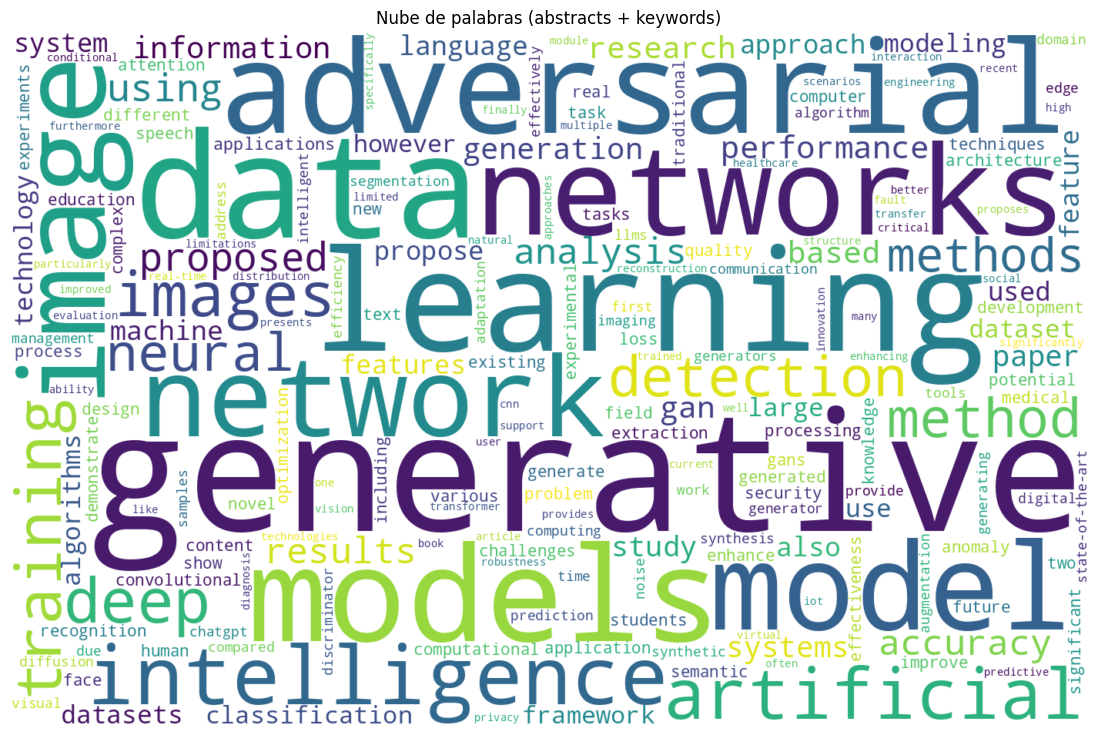

Nube guardada en outputs/nube_palabras.png
PDF generado en outputs/nube_palabras.pdf


In [29]:
# Generar nube de palabras y guardar PNG/PDF
import json
import re
from collections import Counter
from pathlib import Path

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = Path('data')
records_path = DATA_DIR / 'records.csv'
freq_path = DATA_DIR / 'frequencies.json'

if not records_path.exists():
    raise FileNotFoundError(f"No se encontró {records_path}. Ejecuta la celda de parseo antes.")

import pandas as pd
records = pd.read_csv(records_path, dtype=str).fillna('')

# Construir corpus: abstracts + keywords
texts = (records['abstract'].fillna('') + ' ' + records.get('keywords', '').fillna(''))

# Tokenización básica y limpieza
word_re = re.compile(r"\b[\w'-]{3,}\b", flags=re.UNICODE)

# Stopwords: intentar usar NLTK, si no está simplemente usar una lista corta
try:
    import nltk
    from nltk.corpus import stopwords
    try:
        stopwords.words('spanish')
    except Exception:
        nltk.download('stopwords')
    stop_es = set(stopwords.words('spanish'))
    stop_en = set(stopwords.words('english'))
    STOP = stop_es | stop_en
except Exception:
    STOP = set([ 'the','and','for','with','that','this','from','using','use','research','study','method','results','analysis','based','data','paper' ])

counter = Counter()
for txt in texts:
    for w in word_re.findall(str(txt).lower()):
        if w in STOP:
            continue
        if w.isdigit():
            continue
        counter[w] += 1

# Guardar frecuencias (dinámico)
freq_payload = {'total_terms': sum(counter.values()), 'terms': dict(counter)}
with open(freq_path, 'w', encoding='utf-8') as f:
    json.dump(freq_payload, f, ensure_ascii=False, indent=2)

# Intentar crear nube con wordcloud; si no está, crear gráfico de barras con matplotlib
out_png = OUT_DIR / 'nube_palabras.png'
out_pdf = OUT_DIR / 'nube_palabras.pdf'

# helper para mostrar imágenes inline (Pillow -> IPython)
from IPython.display import display

try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    wc = WordCloud(width=1400, height=900, background_color='white', collocations=False).generate_from_frequencies(counter)

    # Mostrar en notebook
    plt.figure(figsize=(14,9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras (abstracts + keywords)')
    plt.show()

    # Guardar como PNG
    wc.to_file(str(out_png))
    print('Nube guardada en', out_png)

    # Convertir PNG -> PDF con Pillow
    try:
        from PIL import Image
        im = Image.open(out_png).convert('RGB')
        im.save(out_pdf, 'PDF', resolution=300)
        print('PDF generado en', out_pdf)
    except Exception as e:
        print('No se pudo convertir PNG a PDF con Pillow:', e)

except Exception as e:
    print('wordcloud no instalado o error al generar nube:', e)
    # fallback: barras
    import matplotlib.pyplot as plt
    top = counter.most_common(50)
    if not top:
        print('No hay términos para generar la nube/bar chart.')
    else:
        words, freqs = zip(*top)
        plt.figure(figsize=(12,8))
        plt.barh(range(len(words))[::-1], freqs[::-1], color='tab:blue')
        plt.yticks(range(len(words)), [w for w in words][::-1])
        plt.title('Top 50 términos (abstracts + keywords)')
        plt.tight_layout()
        plt.show()
        plt.savefig(out_png, dpi=200)
        print('Bar chart guardado en', out_png)
        try:
            from PIL import Image
            im = Image.open(out_png).convert('RGB')
            im.save(out_pdf, 'PDF', resolution=300)
            print('PDF generado en', out_pdf)
        except Exception as e2:
            print('No se pudo convertir PNG a PDF con Pillow:', e2)

In [30]:
# Línea temporal por fuente: lee los .bib de las carpetas descargas/ieee, descargas/sciencedirect, descargas/springer
import pandas as pd
import bibtexparser
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
from itertools import cycle
import re

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Mapeo de nombres de fuente -> carpeta relativa (en la raíz del proyecto)
SOURCES = {
    'IEEE': Path('../../descargas/ieee/'),
    'ScienceDirect': Path('../../descargas/sciencedirect/'),
    'Taylor': Path('../../descargas/springer/')
}

# regex simple para extraer años cuando el campo 'year' no esté presente
year_re = re.compile(r'\b(19|20)\d{2}\b')

# recolectar conteos por año para cada fuente
source_counts = {}
min_year = None
max_year = None
for name, folder in SOURCES.items():
    counts = {}
    if not folder.exists():
        print(f'Advertencia: carpeta {folder} no encontrada para fuente {name}. Se tratará como vacía.')
        source_counts[name] = counts
        continue
    for bibf in folder.glob('*.bib'):
        try:
            text = bibf.read_text(encoding='utf-8', errors='ignore')
            db = bibtexparser.loads(text)
            for entry in db.entries:
                y = entry.get('year','').strip() if entry.get('year') else ''
                if not y:
                    # intentar buscar año en otros campos o texto bruto
                    raw_text = ' '.join([str(v) for v in entry.values()])
                    m = year_re.search(raw_text)
                    if m:
                        y = m.group(0)
                try:
                    yi = int(y)
                except Exception:
                    continue
                counts[yi] = counts.get(yi, 0) + 1
                if min_year is None or yi < min_year:
                    min_year = yi
                if max_year is None or yi > max_year:
                    max_year = yi
        except Exception as e:
            print('Error leyendo', bibf, ':', e)
    source_counts[name] = counts

# Si no se encontró ningún año, abortar con aviso
if min_year is None:
    print('No se encontraron años válidos en las fuentes especificadas. Verifica los .bib en descargas/.')
else:
    YEARS = list(range(min_year, max_year + 1))
    df = pd.DataFrame(index=YEARS)
    for name, counts in source_counts.items():
        df[name] = [counts.get(y, 0) for y in YEARS]
    df['Total'] = df.sum(axis=1)

    # Gráfica con Plotly (Total + fuentes)
    palette = px.colors.qualitative.Plotly
    color_cycle = cycle(palette)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=YEARS, y=df['Total'].values, mode='lines+markers', name='Total publicaciones', line=dict(width=4, color='black')))
    for col in df.columns.drop('Total'):
        color = next(color_cycle)
        fig.add_trace(go.Scatter(x=YEARS, y=df[col].values, mode='lines+markers', name=col, line=dict(width=2, color=color)))

    fig.update_layout(title='Línea temporal por fuente (IEEE / ScienceDirect / Taylor)', xaxis_title='Año', yaxis_title='Número de publicaciones', width=1200, height=600, legend=dict(orientation='v', x=1.02, y=1))
    if len(YEARS) > 15:
        fig.update_xaxes(tickangle=-45, dtick=1)
    else:
        fig.update_xaxes(dtick=1)
    fig.show()

    # Guardar salidas (PNG/PDF) o HTML como fallback
    out_png = OUT_DIR / 'linea_tiempo_by_source.png'
    out_pdf = OUT_DIR / 'linea_tiempo_by_source.pdf'
    saved = False
    try:
        fig.write_image(str(out_png), format='png', engine='kaleido', width=1200, height=600, scale=2)
        try:
            from PIL import Image
            im = Image.open(out_png).convert('RGB')
            im.save(out_pdf, 'PDF', resolution=300)
            print('Guardado (PNG -> PDF):', out_png, out_pdf)
            saved = True
        except Exception as e:
            print('PNG guardado pero fallo conversión a PDF por Pillow:', e)
            saved = True
    except Exception as e:
        print('No se pudo exportar PNG con kaleido:', e)
    if not saved:
        try:
            fig.write_html(OUT_DIR / 'linea_tiempo_by_source.html')
            print('Exportado a HTML interactivo como fallback')
        except Exception as e:
            print('Falló exportación de la figura:', e)

    print('Series mostradas (incluye Total):', len(df.columns))


/tmp/ipykernel_65056/3759376824.py:89: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




Guardado (PNG -> PDF): outputs/linea_tiempo_by_source.png outputs/linea_tiempo_by_source.pdf
Series mostradas (incluye Total): 4


## Combinar PDFs y generar informe final

Combina `mapa_paises.pdf`, `nube_palabras.pdf` y `linea_tiempo.pdf` en `outputs/requerimiento5_report.pdf`. Si no está disponible `PyPDF2`, muestra las rutas de los archivos para que puedas combinarlos manualmente.


In [31]:
# Combinar PDFs en un único informe
from pathlib import Path
OUT_DIR = Path('outputs')
files = [OUT_DIR / 'mapa_paises.pdf', OUT_DIR / 'nube_palabras.pdf', OUT_DIR / 'linea_tiempo_by_source.pdf']
available = [f for f in files if f.exists()]

if not available:
    print('No se encontraron los PDFs esperados en outputs/. Asegúrate de ejecutar las celdas de generación antes.')
    for f in files:
        print('-', f)
else:
    try:
        from PyPDF2 import PdfMerger
        merger = PdfMerger()
        for f in files:
            if f.exists():
                merger.append(str(f))
        out = OUT_DIR / 'requerimiento5_report.pdf'
        merger.write(str(out))
        merger.close()
        print('Informe combinado generado en', out)
    except Exception as e:
        print('No se pudo combinar con PyPDF2:', e)
        print('Archivos disponibles:')
        for f in available:
            print('-', f)
        print('Puedes combinarlos manualmente o instalar PyPDF2 (pip install PyPDF2)')


Informe combinado generado en outputs/requerimiento5_report.pdf


## Sistema de Actualización Automática

Este módulo detecta automáticamente nuevos estudios agregados al archivo BibTeX y actualiza:
1. **Frecuencias de palabras** (`frequencies.json`) - Actualización incremental
2. **Nube de palabras** (regenera PNG/PDF)
3. **Mapa de países** (si hay nuevos países)
4. **Línea temporal** (si hay nuevos años)
5. **PDF consolidado** (requerimiento5_report.pdf)

### Funcionamiento:
- Compara el número de registros actuales con los del cache
- Si detecta nuevos registros, procesa solo los nuevos
- Actualiza las visualizaciones incrementalmente
- Mantiene un log de actualizaciones en `data/update_log.json`

### Uso:
Simplemente ejecuta la celda siguiente. El sistema:
1. Detectará automáticamente si hay nuevos estudios
2. Procesará solo los nuevos (sin reprocesar los existentes)
3. Actualizará todas las visualizaciones
4. Generará un reporte con las estadísticas de actualización


In [32]:
# Sistema de Actualización Automática
import json
import pandas as pd
from pathlib import Path
from datetime import datetime
from collections import Counter
import re

# Configuración
BIB_PATH = '../primeros_500.bib'
DATA_DIR = Path('data')
OUT_DIR = Path('outputs')
UPDATE_LOG_PATH = DATA_DIR / 'update_log.json'

def load_update_log():
    """Carga el historial de actualizaciones"""
    if UPDATE_LOG_PATH.exists():
        with open(UPDATE_LOG_PATH, 'r', encoding='utf-8') as f:
            return json.load(f)
    return {'updates': [], 'last_record_count': 0, 'last_update': None}

def save_update_log(log):
    """Guarda el historial de actualizaciones"""
    with open(UPDATE_LOG_PATH, 'w', encoding='utf-8') as f:
        json.dump(log, f, indent=2, ensure_ascii=False)

def detect_new_records(bib_path, last_count):
    """Detecta si hay nuevos registros en el archivo BibTeX"""
    df = parse_bib_to_df(bib_path, max_entries=None)
    current_count = len(df)
    new_records = current_count - last_count
    return df, current_count, new_records

def update_frequencies_incremental(new_records_df, freq_path):
    """Actualiza frequencies.json de forma incremental"""
    # Cargar frecuencias existentes
    if freq_path.exists():
        with open(freq_path, 'r', encoding='utf-8') as f:
            freq_data = json.load(f)
        existing_terms = freq_data.get('terms', {})
        existing_total = freq_data.get('total_terms', 0)
    else:
        existing_terms = {}
        existing_total = 0
    
    # Procesar nuevos abstracts y keywords
    word_re = re.compile(r"\b[\w'-]{3,}\b", flags=re.UNICODE)
    
    # Stopwords básicas
    try:
        import nltk
        from nltk.corpus import stopwords
        STOP = set(stopwords.words('spanish')) | set(stopwords.words('english'))
    except:
        STOP = set(['the','and','for','with','that','this','from','using','use',
                   'research','study','method','results','analysis','based','data','paper'])
    
    new_counter = Counter()
    texts = (new_records_df['abstract'].fillna('') + ' ' + 
             new_records_df.get('keywords', '').fillna(''))
    
    for txt in texts:
        for w in word_re.findall(str(txt).lower()):
            if w in STOP or w.isdigit():
                continue
            new_counter[w] += 1
    
    # Combinar con existentes
    for term, count in new_counter.items():
        existing_terms[term] = existing_terms.get(term, 0) + count
    
    # Guardar actualizado
    updated_data = {
        'total_terms': existing_total + sum(new_counter.values()),
        'terms': existing_terms,
        'last_updated': datetime.now().isoformat(),
        'new_terms_added': sum(new_counter.values())
    }
    
    with open(freq_path, 'w', encoding='utf-8') as f:
        json.dump(updated_data, f, indent=2, ensure_ascii=False)
    
    return updated_data, len(new_counter)

def regenerate_visualizations():
    """Regenera todas las visualizaciones con los datos actualizados"""
    print("\n Regenerando visualizaciones...")
    
    # 1. Mapa de países
    print(" Actualizando mapa de países...")
    try:
        exec(open('generate_map.py').read()) if Path('generate_map.py').exists() else None
        print("Mapa actualizado")
    except Exception as e:
        print(f"Error actualizando mapa: {e}")
    
    # 2. Nube de palabras
    print(" Actualizando nube de palabras...")
    try:
        from wordcloud import WordCloud
        import matplotlib.pyplot as plt
        
        freq_path = DATA_DIR / 'frequencies.json'
        with open(freq_path, 'r', encoding='utf-8') as f:
            freq_data = json.load(f)
        
        counter = Counter(freq_data['terms'])
        wc = WordCloud(width=1400, height=900, background_color='white', 
                      collocations=False).generate_from_frequencies(counter)
        
        out_png = OUT_DIR / 'nube_palabras.png'
        wc.to_file(str(out_png))
        
        from PIL import Image
        im = Image.open(out_png).convert('RGB')
        im.save(OUT_DIR / 'nube_palabras.pdf', 'PDF', resolution=300)
        print("Nube de palabras actualizada")
    except Exception as e:
        print(f"Error actualizando nube: {e}")
    
    # 3. PDF consolidado
    print(" Regenerando PDF consolidado...")
    try:
        from PyPDF2 import PdfMerger
        files = [OUT_DIR / 'mapa_paises.pdf', OUT_DIR / 'nube_palabras.pdf', 
                OUT_DIR / 'linea_tiempo_by_source.pdf']
        merger = PdfMerger()
        for f in files:
            if f.exists():
                merger.append(str(f))
        merger.write(str(OUT_DIR / 'requerimiento5_report.pdf'))
        merger.close()
        print("PDF consolidado actualizado")
    except Exception as e:
        print(f"Error regenerando PDF: {e}")

# ==================== EJECUCIÓN PRINCIPAL ====================
print("🔍 Verificando actualizaciones...")
print("="*60)

# Cargar log de actualizaciones
update_log = load_update_log()
last_count = update_log.get('last_record_count', 0)

print(f"Registros previos: {last_count}")

# Detectar nuevos registros
df_current, current_count, new_count = detect_new_records(BIB_PATH, last_count)

if new_count > 0:
    print(f"Nuevos registros detectados: {new_count}")
    print(f"Total actual: {current_count}")
    print("\n Iniciando actualización automática...")
    print("-"*60)
    
    # Obtener solo los nuevos registros
    new_records = df_current.iloc[last_count:]
    
    # 1. Actualizar frecuencias incrementalmente
    print(" Actualizando frecuencias de palabras...")
    freq_path = DATA_DIR / 'frequencies.json'
    updated_freq, new_unique_terms = update_frequencies_incremental(new_records, freq_path)
    print(f"  Agregados {updated_freq['new_terms_added']} términos")
    print(f"  Términos únicos nuevos: {new_unique_terms}")
    
    # 2. Actualizar cache de países (solo nuevos registros)
    print(" Enriqueciendo nuevos registros con Crossref...")
    cache_path = DATA_DIR / 'country_lookup.csv'
    cache = batch_enrich(new_records, cache_path=str(cache_path), 
                        email='', sleep=1.0, max_rows=None)
    new_countries = sum(1 for v in cache.values() if v.get('country'))
    print(f"  Países identificados en nuevos registros: {new_countries}/{new_count}")
    
    # 3. Actualizar records.csv
    print(" Actualizando records.csv...")
    records_path = DATA_DIR / 'records.csv'
    df_current.to_csv(records_path, index=False, encoding='utf-8')
    print(f" Guardados {current_count} registros totales")
    
    # 4. Regenerar visualizaciones
    regenerate_visualizations()
    
    # 5. Actualizar log
    update_entry = {
        'timestamp': datetime.now().isoformat(),
        'new_records': new_count,
        'total_records': current_count,
        'new_countries_identified': new_countries,
        'new_terms_added': updated_freq['new_terms_added']
    }
    update_log['updates'].append(update_entry)
    update_log['last_record_count'] = current_count
    update_log['last_update'] = datetime.now().isoformat()
    save_update_log(update_log)
    
    print("\n" + "="*60)
    print("ACTUALIZACIÓN COMPLETADA")
    print("="*60)
    print(f"Resumen:")
    print(f"  • Nuevos registros procesados: {new_count}")
    print(f"  • Total de registros: {current_count}")
    print(f"  • Nuevos países identificados: {new_countries}")
    print(f"  • Términos agregados: {updated_freq['new_terms_added']}")
    print(f"  • Términos únicos totales: {len(updated_freq['terms']):,}")
    print(f"\nArchivos actualizados:")
    print(f"  • {freq_path}")
    print(f"  • {cache_path}")
    print(f"  • {records_path}")
    print(f"  • {OUT_DIR}/nube_palabras.png")
    print(f"  • {OUT_DIR}/requerimiento5_report.pdf")
    
else:
    print(f"No hay nuevos registros. Total actual: {current_count}")
    print(f"Última actualización: {update_log.get('last_update', 'Nunca')}")
    
    if update_log.get('updates'):
        print(f"\n Historial de actualizaciones ({len(update_log['updates'])} actualizaciones):")
        for i, upd in enumerate(update_log['updates'][-5:], 1):  # Últimas 5
            print(f"  {i}. {upd['timestamp'][:19]} - {upd['new_records']} nuevos registros")

print("\n" + "="*60)

🔍 Verificando actualizaciones...
Registros previos: 0
Nuevos registros detectados: 500
Total actual: 500

 Iniciando actualización automática...
------------------------------------------------------------
 Actualizando frecuencias de palabras...
  Agregados 66326 términos
  Términos únicos nuevos: 8078
 Enriqueciendo nuevos registros con Crossref...


100%|██████████| 500/500 [00:00<00:00, 42844.49it/s]

  Países identificados en nuevos registros: 500/500
 Actualizando records.csv...
 Guardados 500 registros totales

 Regenerando visualizaciones...
 Actualizando mapa de países...
Mapa actualizado
 Actualizando nube de palabras...


Nube de palabras actualizada
 Regenerando PDF consolidado...
PDF consolidado actualizado

ACTUALIZACIÓN COMPLETADA
Resumen:
  • Nuevos registros procesados: 500
  • Total de registros: 500
  • Nuevos países identificados: 500
  • Términos agregados: 66326
  • Términos únicos totales: 8,078

Archivos actualizados:
  • data/frequencies.json
  • data/country_lookup.csv
  • data/records.csv
  • outputs/nube_palabras.png
  • outputs/requerimiento5_report.pdf




## Monitoreo y Estadísticas de Actualización

Esta celda proporciona funciones útiles para:
- Ver el historial completo de actualizaciones
- Comparar estadísticas entre actualizaciones
- Visualizar el crecimiento del dataset
- Exportar reportes de actualización


🔍 Ejecutando análisis de monitoreo...

\n HISTORIAL DE ACTUALIZACIONES
\nTotal de actualizaciones: 1
Primera actualización: 2025-11-05 19:17:10.791301
Última actualización: 2025-11-05 19:17:10.791301
\nRegistros totales actuales: 500
\n--------------------------------------------------------------------------------
Fecha                Nuevos     Total      Países     Términos  
--------------------------------------------------------------------------------
2025-11-05 19:17     500        500        500        66326     

ESTADÍSTICAS ACTUALES DEL DATASET

 Registros:
  • Total de artículos: 500
  • Con DOI: 474 (94.8%)
  • Rango de años: 2005 - 2025

 Países:
  • Artículos con país: 367 (73.4%)
  • Países únicos: 50

  Top 10 países:
     1. China                  163 artículos
     2. India                   46 artículos
     3. United States           45 artículos
     4. United Kingdom          10 artículos
     5. Italy                    8 artículos
     6. Australia            

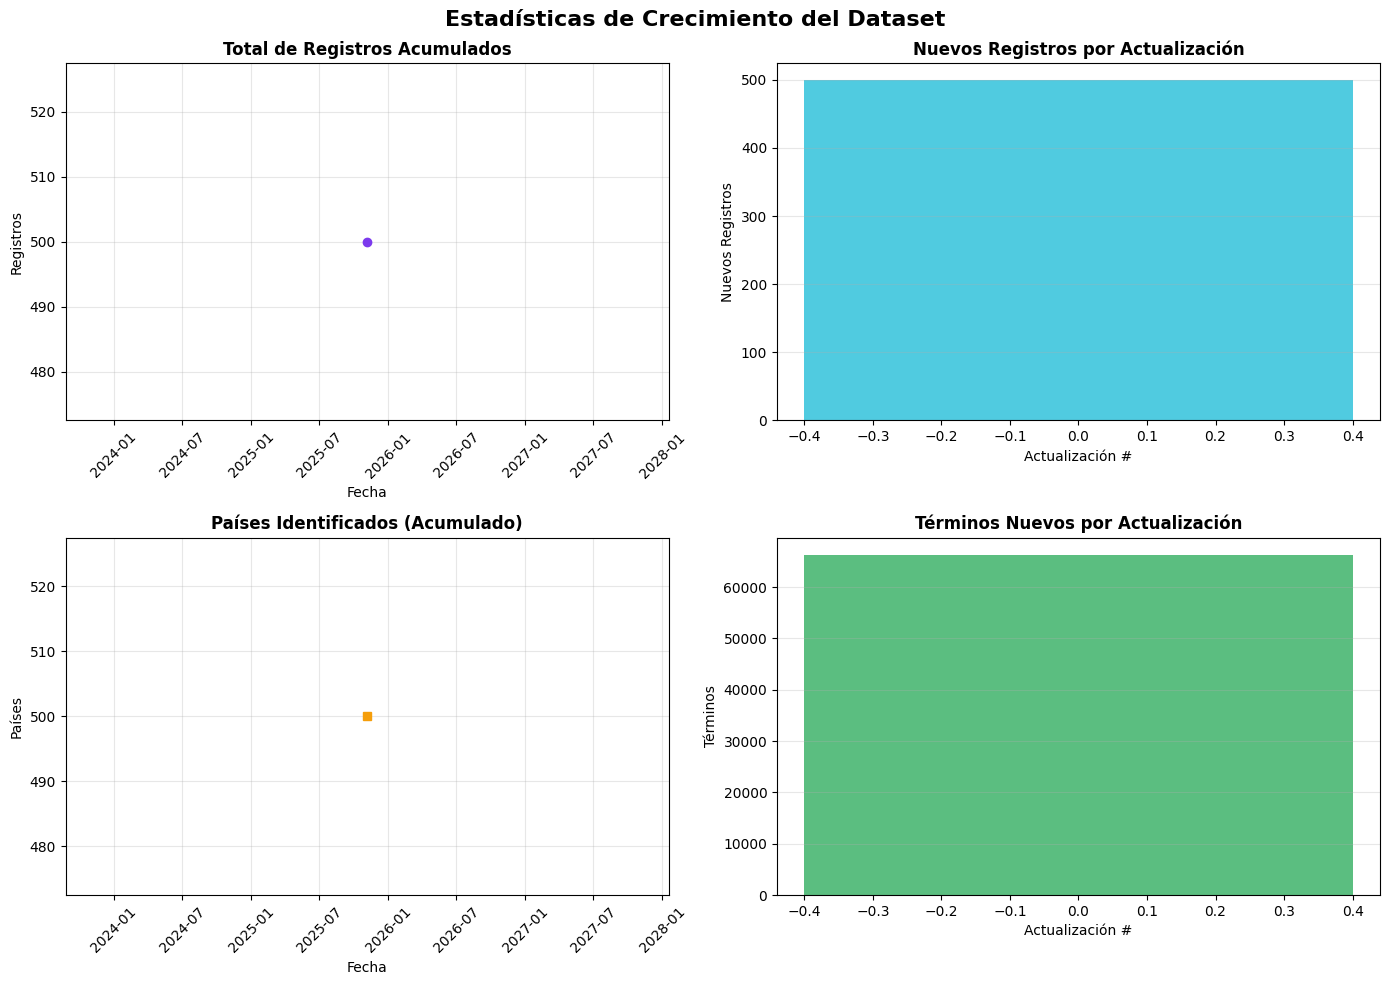

 Gráfico guardado en data/update_statistics.png

Para exportar reporte detallado, ejecuta: export_update_report()


In [33]:
# Funciones de Monitoreo y Estadísticas
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime

DATA_DIR = Path('data')
UPDATE_LOG_PATH = DATA_DIR / 'update_log.json'

def show_update_history():
    """Muestra el historial completo de actualizaciones"""
    if not UPDATE_LOG_PATH.exists():
        print("No hay historial de actualizaciones disponible")
        return
    
    with open(UPDATE_LOG_PATH, 'r', encoding='utf-8') as f:
        log = json.load(f)
    
    if not log.get('updates'):
        print("No hay actualizaciones registradas aún")
        return
    
    print("\\n HISTORIAL DE ACTUALIZACIONES")
    print("="*80)
    
    df = pd.DataFrame(log['updates'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp', ascending=False)
    
    print(f"\\nTotal de actualizaciones: {len(df)}")
    print(f"Primera actualización: {df['timestamp'].min()}")
    print(f"Última actualización: {df['timestamp'].max()}")
    print(f"\\nRegistros totales actuales: {log.get('last_record_count', 0):,}")
    
    print("\\n" + "-"*80)
    print(f"{'Fecha':<20} {'Nuevos':<10} {'Total':<10} {'Países':<10} {'Términos':<10}")
    print("-"*80)
    
    for _, row in df.iterrows():
        fecha = row['timestamp'].strftime('%Y-%m-%d %H:%M')
        print(f"{fecha:<20} {row['new_records']:<10} {row['total_records']:<10} "
              f"{row.get('new_countries_identified', 0):<10} {row.get('new_terms_added', 0):<10}")
    
    return df

def plot_growth_statistics():
    """Visualiza el crecimiento del dataset a lo largo del tiempo"""
    if not UPDATE_LOG_PATH.exists():
        print("❌ No hay datos para visualizar")
        return
    
    with open(UPDATE_LOG_PATH, 'r', encoding='utf-8') as f:
        log = json.load(f)
    
    if not log.get('updates'):
        print("No hay suficientes datos para graficar")
        return
    
    df = pd.DataFrame(log['updates'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Estadísticas de Crecimiento del Dataset', fontsize=16, fontweight='bold')
    
    # 1. Total de registros acumulados
    axes[0, 0].plot(df['timestamp'], df['total_records'], marker='o', linewidth=2, color='#7c3aed')
    axes[0, 0].set_title('Total de Registros Acumulados', fontweight='bold')
    axes[0, 0].set_xlabel('Fecha')
    axes[0, 0].set_ylabel('Registros')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Nuevos registros por actualización
    axes[0, 1].bar(range(len(df)), df['new_records'], color='#06b6d4', alpha=0.7)
    axes[0, 1].set_title('Nuevos Registros por Actualización', fontweight='bold')
    axes[0, 1].set_xlabel('Actualización #')
    axes[0, 1].set_ylabel('Nuevos Registros')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Países identificados acumulados
    if 'new_countries_identified' in df.columns:
        axes[1, 0].plot(df['timestamp'], df['new_countries_identified'].cumsum(), 
                       marker='s', linewidth=2, color='#f59e0b')
        axes[1, 0].set_title('Países Identificados (Acumulado)', fontweight='bold')
        axes[1, 0].set_xlabel('Fecha')
        axes[1, 0].set_ylabel('Países')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Términos agregados por actualización
    if 'new_terms_added' in df.columns:
        axes[1, 1].bar(range(len(df)), df['new_terms_added'], color='#16a34a', alpha=0.7)
        axes[1, 1].set_title('Términos Nuevos por Actualización', fontweight='bold')
        axes[1, 1].set_xlabel('Actualización #')
        axes[1, 1].set_ylabel('Términos')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Guardar gráfico
    fig.savefig(DATA_DIR / 'update_statistics.png', dpi=150, bbox_inches='tight')
    print(f" Gráfico guardado en {DATA_DIR / 'update_statistics.png'}")

def export_update_report():
    """Exporta un reporte detallado de actualizaciones en CSV"""
    if not UPDATE_LOG_PATH.exists():
        print(" No hay datos para exportar")
        return
    
    with open(UPDATE_LOG_PATH, 'r', encoding='utf-8') as f:
        log = json.load(f)
    
    if not log.get('updates'):
        print("No hay actualizaciones para exportar")
        return
    
    df = pd.DataFrame(log['updates'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    report_path = DATA_DIR / 'update_report.csv'
    df.to_csv(report_path, index=False, encoding='utf-8')
    
    print(f"Reporte exportado a {report_path}")
    print(f"Registros en el reporte: {len(df)}")
    
    return df

def get_current_statistics():
    """Muestra estadísticas actuales del dataset"""
    print("\nESTADÍSTICAS ACTUALES DEL DATASET")
    print("="*60)
    
    # Records
    records_path = DATA_DIR / 'records.csv'
    if records_path.exists():
        df = pd.read_csv(records_path)
        print(f"\n Registros:")
        print(f"  • Total de artículos: {len(df):,}")
        print(f"  • Con DOI: {df['doi'].notna().sum():,} ({df['doi'].notna().sum()/len(df)*100:.1f}%)")
        print(f"  • Rango de años: {df['year'].min()} - {df['year'].max()}")
    
    # Countries
    cache_path = DATA_DIR / 'country_lookup.csv'
    if cache_path.exists():
        cache = pd.read_csv(cache_path)
        countries_identified = cache['country'].notna().sum()
        unique_countries = cache['country'].nunique()
        print(f"\n Países:")
        print(f"  • Artículos con país: {countries_identified:,} ({countries_identified/len(cache)*100:.1f}%)")
        print(f"  • Países únicos: {unique_countries}")
        print(f"\n  Top 10 países:")
        top_countries = cache['country'].value_counts().head(10)
        for i, (country, count) in enumerate(top_countries.items(), 1):
            print(f"    {i:2}. {country:<20} {count:>5} artículos")
    
    # Frequencies
    freq_path = DATA_DIR / 'frequencies.json'
    if freq_path.exists():
        with open(freq_path, 'r', encoding='utf-8') as f:
            freq_data = json.load(f)
        print(f"\n Términos:")
        print(f"  • Total de términos: {freq_data.get('total_terms', 0):,}")
        print(f"  • Términos únicos: {len(freq_data.get('terms', {})):,}")
        print(f"  • Última actualización: {freq_data.get('last_updated', 'N/A')[:19]}")
        
        # Top 10 términos
        terms = freq_data.get('terms', {})
        top_terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)[:10]
        print(f"\\n  Top 10 términos:")
        for i, (term, count) in enumerate(top_terms, 1):
            print(f"    {i:2}. {term:<20} {count:>5} ocurrencias")
    
    print("\\n" + "="*60)

# ==================== EJECUTAR FUNCIONES ====================
print("🔍 Ejecutando análisis de monitoreo...")
print()

# 1. Mostrar historial
df_history = show_update_history()

# 2. Estadísticas actuales
get_current_statistics()

# 3. Visualizar crecimiento (si hay datos)
if df_history is not None and len(df_history) > 0:
    print("\nGenerando gráficos de crecimiento...")
    plot_growth_statistics()

# 4. Opción para exportar reporte
print("\nPara exportar reporte detallado, ejecuta: export_update_report()")